<a href="https://colab.research.google.com/github/M-ballabio1/DataScience_ML_DL-projects/blob/main/3.Seasonal_ARIMA%20-%20Forecasting%20Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 8.3 MB/s 
     |████████████████████████████████| 9.8 MB 54.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [132]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import statsmodels as sm
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import seaborn as sns
from pmdarima.arima import auto_arima
from sklearn.linear_model import Lasso , LassoCV , Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


import warnings 
warnings.filterwarnings("ignore")

In [4]:
from google.colab import files 

df = files.upload()

Saving Dataset_AQ.xlsx to Dataset_AQ.xlsx


In [5]:
df = pd.read_excel('Dataset_AQ.xlsx')
print(df)


                     Date  BlackCarbon  ...  Relative_humidity  Temperature
0    2014-01-05T23:00:00Z     4.940000  ...          88.612927     2.569692
1    2014-01-12T23:00:00Z     7.240000  ...          83.934511     5.487934
2    2014-01-19T23:00:00Z     4.585714  ...          91.254229     3.020901
3    2014-01-26T23:00:00Z     5.500000  ...          74.341920     4.766052
4    2014-02-02T23:00:00Z     3.642857  ...          87.962498     2.564018
..                    ...          ...  ...                ...          ...
308  2019-12-01T23:00:00Z     3.466667  ...          87.507713     6.633415
309  2019-12-08T23:00:00Z     2.850000  ...          78.335394     3.547048
310  2019-12-15T23:00:00Z     2.980000  ...          76.884068     2.499465
311  2019-12-22T23:00:00Z     3.557143  ...          94.809078     6.673679
312  2019-12-29T23:00:00Z     3.233333  ...          66.618533     4.163620

[313 rows x 11 columns]


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df

,Date,BlackCarbon,Carbon_Monoxide,Nitric_Oxigen,Nitrogen_Dioxide,Other,Ozone,PM10,PM2.5,Relative_humidity,Temperature
0,2014-01-05 23:00:00+00:00,4.940000,1.131926,86.343883,39.274285,3.079632,10.433822,39.816493,35.867097,88.612927,2.569692
1,2014-01-12 23:00:00+00:00,7.240000,1.262728,137.552704,44.407672,3.771451,8.085711,54.147144,42.487306,83.934511,5.487934
2,2014-01-19 23:00:00+00:00,4.585714,1.069887,104.035676,41.050989,3.183397,8.994553,31.279041,24.851380,91.254229,3.020901
3,2014-01-26 23:00:00+00:00,5.500000,0.980521,125.212004,43.558825,3.610101,16.541452,36.914636,27.714028,74.341920,4.766052
4,2014-02-02 23:00:00+00:00,3.642857,0.930767,91.325346,42.979772,3.125399,14.782626,36.176093,29.548442,87.962498,2.564018
...,...,...,...,...,...,...,...,...,...,...,...
308,2019-12-01 23:00:00+00:00,3.466667,0.714729,78.893047,32.958568,2.662906,11.360726,25.628122,19.451488,87.507713,6.633415
309,2019-12-08 23:00:00+00:00,2.850000,0.846985,106.568574,41.274109,2.987834,12.406892,40.740306,32.548546,78.335394,3.547048
310,2019-12-15 23:00:00+00:00,2.980000,0.825581,99.064946,44.437904,3.141001,15.285071,36.579938,30.130722,76.884068,2.499465
311,2019-12-22 23:00:00+00:00,3.557143,0.840518,95.077217,35.146074,2.861242,13.521588,29.002498,22.205184,94.809078,6.673679


In [8]:
df.describe()

,BlackCarbon,Carbon_Monoxide,Nitric_Oxigen,Nitrogen_Dioxide,Other,Ozone,PM10,PM2.5,Relative_humidity,Temperature
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,2.598477,0.585677,59.354691,30.653090,3.062523,48.705469,30.786863,22.809449,72.737167,12.191685
std,1.743289,0.242372,39.534197,11.165462,0.521420,29.228117,14.680698,12.528847,10.102477,7.211864
min,0.700000,0.290381,15.816408,12.648937,1.912743,6.208993,11.451261,7.725092,44.345374,-1.487782
25%,1.292857,0.397454,29.124295,21.239814,2.667040,20.316208,19.179523,13.131349,65.899244,5.487934
50%,1.978571,0.492334,42.924635,28.182365,3.061556,47.811962,27.073591,18.796536,73.394709,12.131573
75%,3.400000,0.760771,82.772673,39.724326,3.411775,71.211267,38.198325,29.921234,79.059156,18.537600
max,9.785714,1.354504,203.930299,63.515094,4.702102,119.455520,90.997589,72.621443,95.285244,26.290979


In [9]:
#Conta i valori nulli
df.isnull().value_counts()

Date   BlackCarbon  Carbon_Monoxide  Nitric_Oxigen  Nitrogen_Dioxide  Other  Ozone  PM10   PM2.5  Relative_humidity  Temperature
False  False        False            False          False             False  False  False  False  False              False          313
dtype: int64

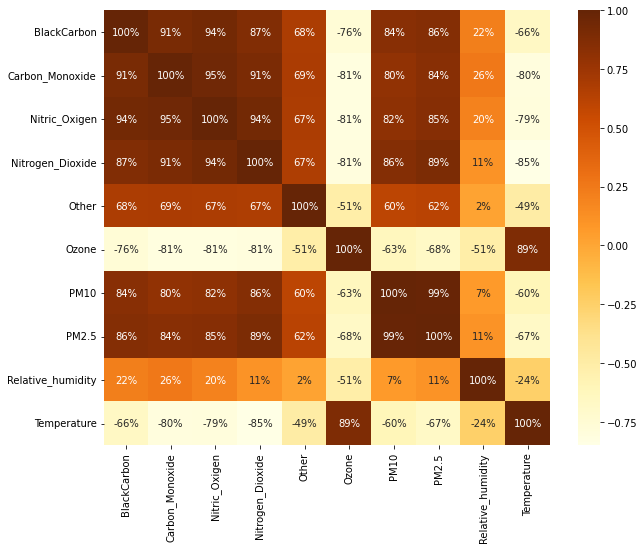

In [10]:
sns.heatmap(df.corr(), annot=True, cmap='YlOrBr', fmt='.0%')
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

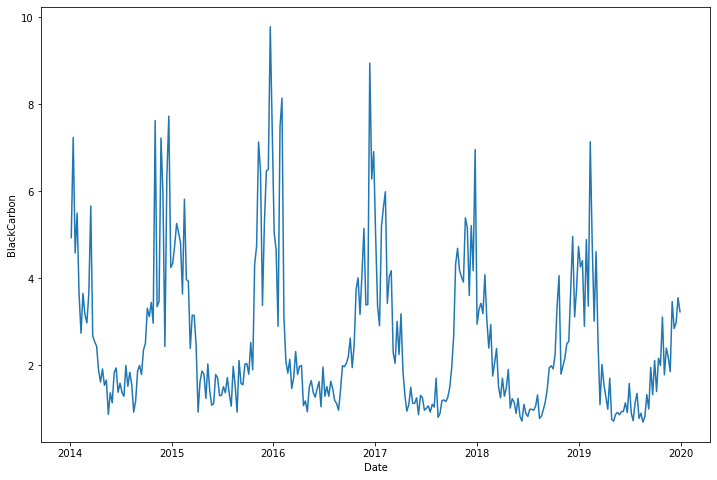

In [222]:
#Plot --> noto estrema stagionalità sui livelli di Ozono
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x='Date', y= 'Temperature')

### Lasso

In statistica e in machine learning, il Lasso (operatore di restringimento e selezione minimo assoluto) è un metodo di analisi di regressione che esegue sia la selezione delle variabili che la regolarizzazione al fine di migliorare l'accuratezza della previsione e l'interpretabilità del modello statistico risultante.

In [116]:
X = df.drop(['Date','Temperature'], axis=1)
X

,BlackCarbon,Carbon_Monoxide,Nitric_Oxigen,Nitrogen_Dioxide,Other,Ozone,PM10,PM2.5,Relative_humidity
0,4.940000,1.131926,86.343883,39.274285,3.079632,10.433822,39.816493,35.867097,88.612927
1,7.240000,1.262728,137.552704,44.407672,3.771451,8.085711,54.147144,42.487306,83.934511
2,4.585714,1.069887,104.035676,41.050989,3.183397,8.994553,31.279041,24.851380,91.254229
3,5.500000,0.980521,125.212004,43.558825,3.610101,16.541452,36.914636,27.714028,74.341920
4,3.642857,0.930767,91.325346,42.979772,3.125399,14.782626,36.176093,29.548442,87.962498
...,...,...,...,...,...,...,...,...,...
308,3.466667,0.714729,78.893047,32.958568,2.662906,11.360726,25.628122,19.451488,87.507713
309,2.850000,0.846985,106.568574,41.274109,2.987834,12.406892,40.740306,32.548546,78.335394
310,2.980000,0.825581,99.064946,44.437904,3.141001,15.285071,36.579938,30.130722,76.884068
311,3.557143,0.840518,95.077217,35.146074,2.861242,13.521588,29.002498,22.205184,94.809078


In [236]:
Y = df.iloc[:,10]
Y

0      2.569692
1      5.487934
2      3.020901
3      4.766052
4      2.564018
         ...   
308    6.633415
309    3.547048
310    2.499465
311    6.673679
312    4.163620
Name: Temperature, Length: 313, dtype: float64

In [63]:
# Create training and test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Alpha:1.00, R2:0.89, MSE:6.33, RMSE:2.52


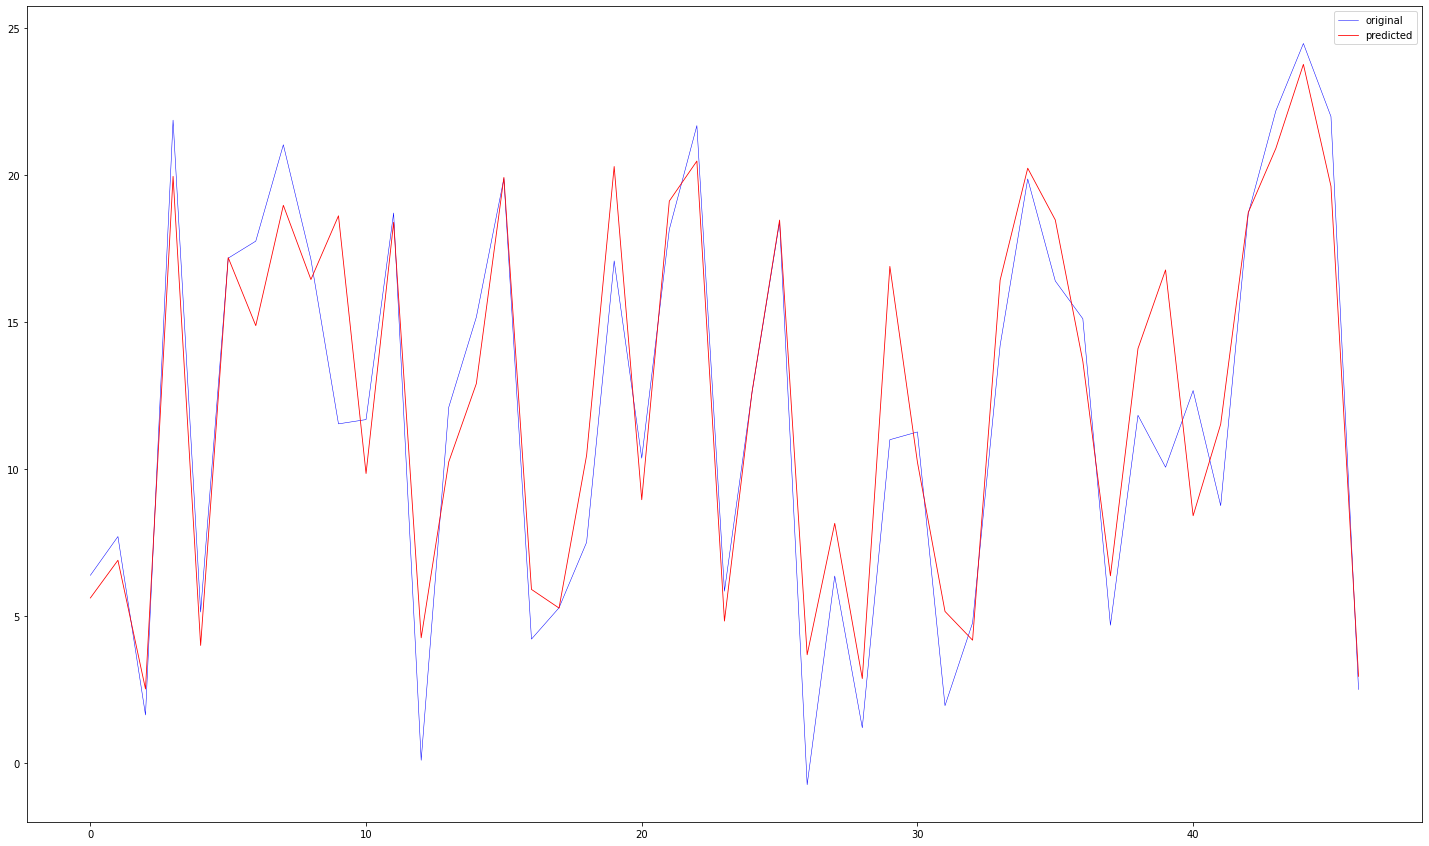

LassoCV(alphas=[0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1], copy_X=True, cv=5,
        eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)
Alpha:0.01, R2:0.940, MSE:4.49, RMSE:2.12


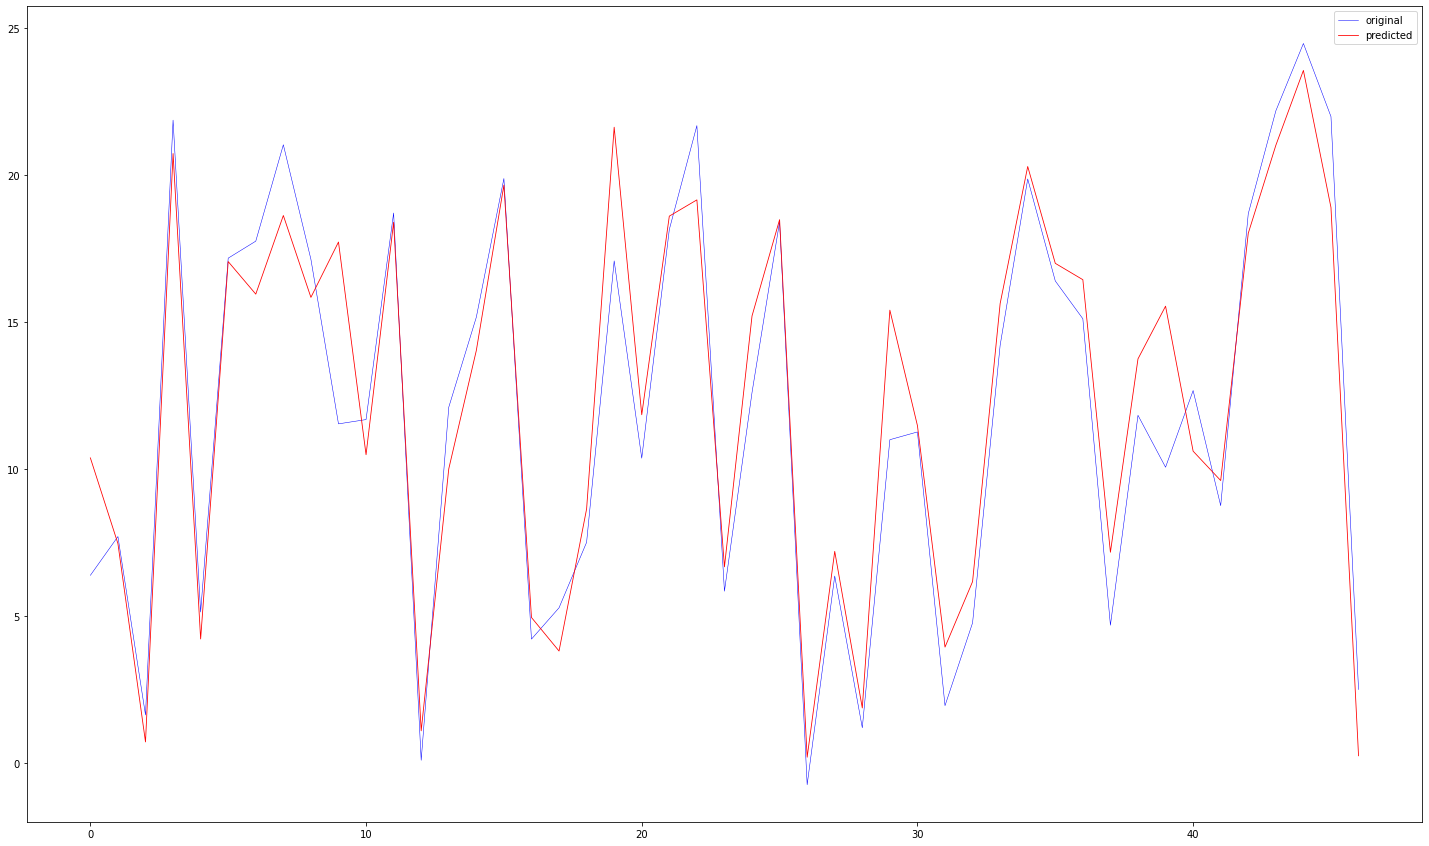

In [136]:
## Lasso
model = Lasso().fit(X_train, y_train) 
print(model)
score = model.score(X, Y)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print("Alpha:{0:.2f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}"
    .format(model.alpha, score, mse, np.sqrt(mse)))

#plot test data
x_ax = range(len(y_pred))
plt.figure(figsize=(25,15))
plt.plot(x_ax, y_test, lw=0.5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

## Lasso with Cross-Validation
alphas = [0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
lassocv = LassoCV(alphas=alphas, cv=5).fit(X,Y)
print(lassocv)
score = lassocv.score(X,Y)
y_pred = lassocv.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print("Alpha:{0:.2f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}"
    .format(lassocv.alpha_, score, mse, np.sqrt(mse)))

#plot test data 
x_ax = range(len(X_test))
plt.figure(figsize=(25,15))
plt.plot(x_ax, y_test, lw=0.5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

### Interpretazione coefficienti

Un coefficiente zero non indica alcuna relazione tra il predittore e la risposta, poiché zero moltiplicato per qualsiasi cosa è zero. Il lasso è speciale in quanto può ridurre a zero i coefficienti beta di alcuni predittori, eliminandoli di fatto dal modello.

In [141]:
names=X.columns
names

Index(['BlackCarbon', 'Carbon_Monoxide', 'Nitric_Oxigen', 'Nitrogen_Dioxide',
       'Other', 'Ozone', 'PM10', 'PM2.5', 'Relative_humidity'],
      dtype='object')

In [142]:
#ci sta dicendo che per l'ottimizzazione del Modello Lasso1 ha portato a 0 alcuni predittori: "BlackCarbon", "Carbon_Monoxide", "Other"
coeff1=model.coef_
coeff1

array([ 0.        , -0.        ,  0.02186265, -0.35534444,  0.        ,
        0.17935758,  0.20983741, -0.12779324,  0.10116501])

([<matplotlib.axis.XTick at 0x7fc30c6e3d10>,
 [Text(0, 0, 'BlackCarbon'),
  Text(0, 0, 'Carbon_Monoxide'),
  Text(0, 0, 'Nitric_Oxigen'),
  Text(0, 0, 'Nitrogen_Dioxide'),
  Text(0, 0, 'Other'),
  Text(0, 0, 'Ozone'),
  Text(0, 0, 'PM10'),
  Text(0, 0, 'PM2.5'),
  Text(0, 0, 'Relative_humidity')])

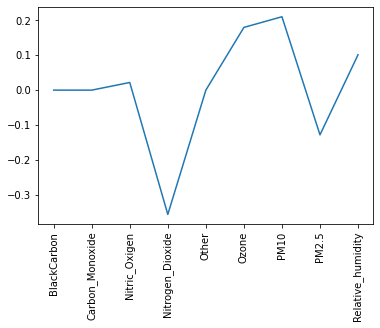

In [143]:
plt.plot(range(len(names)),coeff1)
plt.xticks(range(len(names)),names, rotation=90)

In [144]:
#Nel modello LassoCV sono stati utilizzati tutti i predittori con i seguenti "pesi"
coeff2=lassocv.coef_
coeff2

array([ 1.76746153, -4.05227388, -0.00969307, -0.30172259,  0.49717781,
        0.17688719,  0.6066359 , -0.71473681,  0.11704225])

([<matplotlib.axis.XTick at 0x7fc30c65ee50>,
 [Text(0, 0, 'BlackCarbon'),
  Text(0, 0, 'Carbon_Monoxide'),
  Text(0, 0, 'Nitric_Oxigen'),
  Text(0, 0, 'Nitrogen_Dioxide'),
  Text(0, 0, 'Other'),
  Text(0, 0, 'Ozone'),
  Text(0, 0, 'PM10'),
  Text(0, 0, 'PM2.5'),
  Text(0, 0, 'Relative_humidity')])

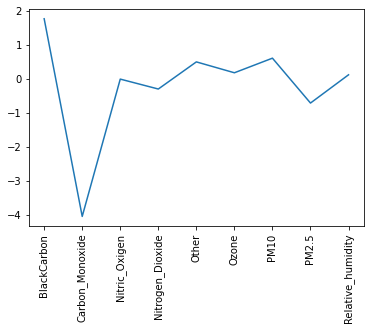

In [145]:
plt.plot(range(len(names)),coeff2)
plt.xticks(range(len(names)),names, rotation=90)

### Best Alpha

### Significato

La regressione con lasso è una tecnica di modellazione comune per eseguire la regolarizzazione. La matematica alla base è piuttosto interessante.
La regressione Lasso viene fornita con un parametro, alpha. Più alto è alpha e più la maggior parte dei coefficienti assume valore zero.

Praticamente:

*   Quando alpha=0, allora nessuno dei coefficienti viene portato a 0 (in pratica stiamo dicendo che sono tutti significativi egualmente, perciò è come se fosse una REGRESSIONE LINEARE SEMPLICE)
*   Quando alpha è molto grande allora, tutti i coefficienti vengono portati a zero e alla fine abbiamo un MODELLO VUOTO.

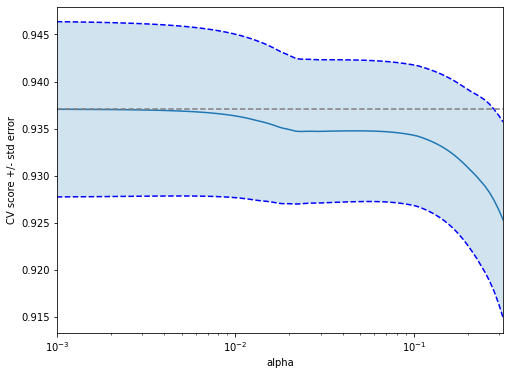

In [77]:
lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-3, -0.5, 100)

tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X_train, y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])

plt.show()

### Testing Stazionarietà

Una serie stazionaria è centrata su un valore, non ha troppi picchi e variazioni impreviste e non mostra drastici cambiamenti di comportamento da una parte all'altra.

Bisogna controllare la stazionarietà per due motivi:

*   I processi stazionari sono più facili da analizzare.
*   La maggior parte degli algoritmi di previsione presuppone che una serie sia stazionaria.




In [286]:
#Testing for stationarity for Temperature  --> Troviamo che è stazionario in quanto p-value << 0.05
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.iloc[:,10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.304691
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


### Autocorrelazione e Autocorrelazione parziale

Interpretazione auto-correlazione: Il modello a seguito mi sta evidenziando che c'è mezza stagionalità nei dati, infatti, i valori che al t=0 sono correlati positivamente con quelli in t=53 circa. Così, come quelli in t=25 sono correlati con quelli in t=78.

Interpretazione auto-correlazione parziale:

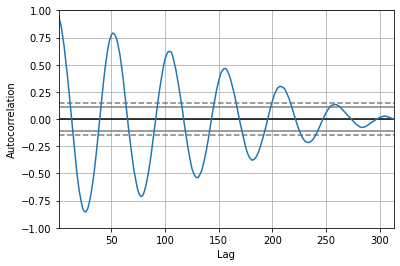

In [154]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(Y)
plt.show()

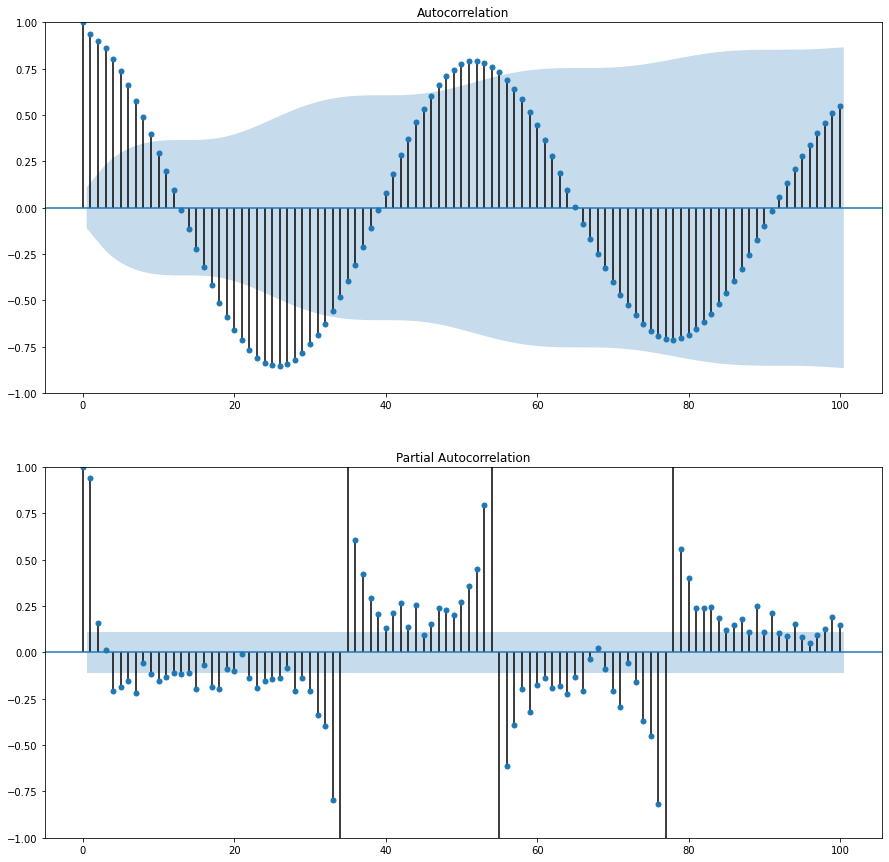

In [165]:
import statsmodels.api as sm

fig, ax = plt.subplots(2,1, figsize=(15,15))
fig = sm.graphics.tsa.plot_acf(Y, lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(Y, lags=100, ax=ax[1])
plt.show()

### ARIMA Model

ARIMA è un acronimo che sta per AutoRegressive Integrated Moving Average. ARIMA comprende due modelli al suo interno: quello autoregressivo detto AR (AutoRegressive) e quello sulle medie mobili MA (Moving Average).

La parte auto regressiva (AR) utilizza la relazione di dipendenza tra un’osservazione e un certo numero di osservazioni ritardate e viene definita nel modello dal parametro p.

Invece la parte di media mobile (MA) utilizza la dipendenza tra un’osservazione e un errore residuo da un modello a media mobile applicato alle osservazioni ritardate. Questo valore è rappresentato dal modello ARIMA con il parametro q.

All’unione di questi due modelli si aggiunge una parte integrata, che permette di gestire la differenziazione di una serie, ossia la differenza di un’osservazione da un’osservazione nella fase temporale precedente.

In [287]:
temperature=df.iloc[:,10]
temperature

0      2.569692
1      5.487934
2      3.020901
3      4.766052
4      2.564018
         ...   
308    6.633415
309    3.547048
310    2.499465
311    6.673679
312    4.163620
Name: Temperature, Length: 313, dtype: float64

In [288]:
#Spliting the dataset into train (>95%) and test (ultimi 5 days)
train = temperature[:299]
test = temperature[-15:]

Text(0, 0.5, 'Temperature')

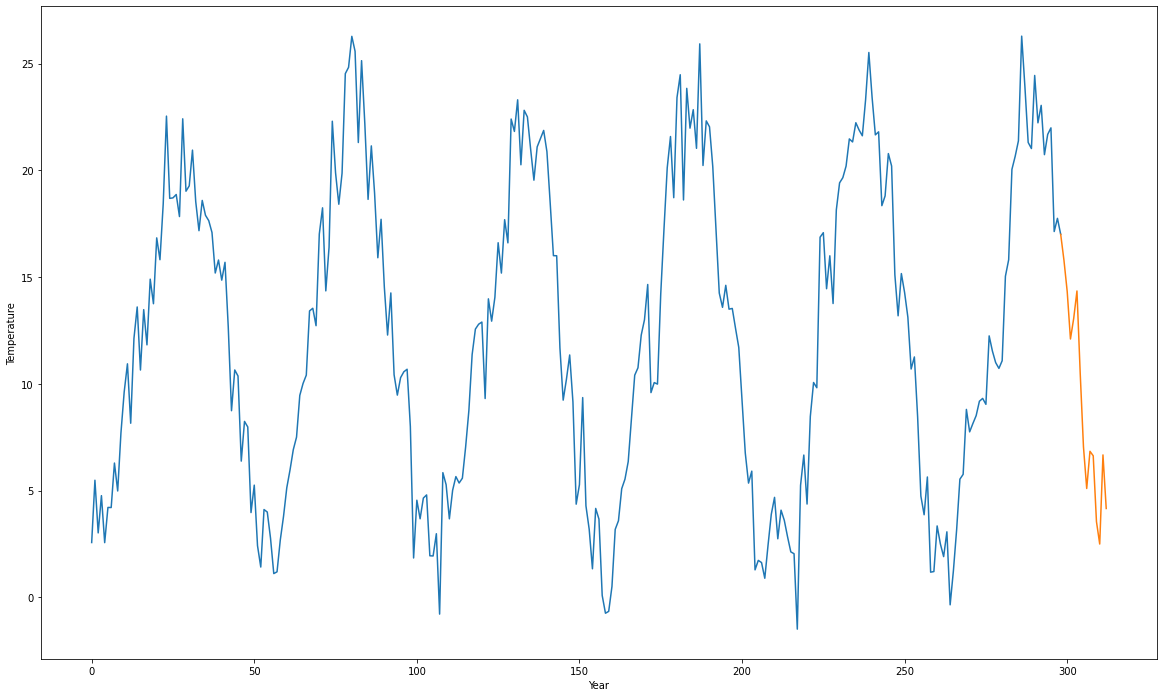

In [289]:
plt.figure(figsize=(20,12))
plt.plot(train)
plt.plot(test)
plt.xlabel('Year')
plt.ylabel('Temperature')

In [290]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=7, max_q=7, start_P=0, 
                          D=1, start_Q=0, max_P=7, max_D=7,
                          max_Q=7, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1508.409, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1458.169, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1502.174, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1419.003, Time=0.41 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1365.197, Time=0.96 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1349.643, Time=1.81 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1346.457, Time=2.55 sec
 ARIMA(1,1,0)(6,1,0)[12]             : AIC=1347.937, Time=4.69 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=20.30 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=18.03 sec
 ARIMA(1,1,0)(6,1,1)[12]             : AIC=inf, Time=33.71 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1365.312, Time=2.16 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=1336.650, Time=3.63 sec
 ARIMA(2,1,0)(4,1,0)[12]            

### **COME INTERPRETARE AIC e BIC?**

##### *AIC - Akaike information criterion:*
Il criterio informativo di Akaike, o AIC, è una metrica che ci dice quanto è buono un modello. Un modello che fa previsioni migliori riceve un punteggio AIC più basso. L'AIC penalizza anche i modelli che hanno molti parametri. Ciò significa che se impostiamo l'ordine troppo alto rispetto ai dati, otterremo un valore AIC elevato. Questo ci impedisce di ottenere l'overfitting.

##### *BIC - Bayesian information criterion:*
Il criterio dell'informazione bayesiana, o BIC, è molto simile all'AIC. I modelli che si adattano meglio ai dati hanno BIC più bassi e il BIC penalizza i modelli eccessivamente complessi.

In [291]:
#Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  299
Model:             SARIMAX(3, 1, 1)x(5, 1, [], 12)   Log Likelihood                -657.713
Date:                             Sat, 06 Nov 2021   AIC                           1335.426
Time:                                     17:21:25   BIC                           1371.986
Sample:                                          0   HQIC                          1350.081
                                             - 299                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4306      0.156      2.765      0.006       0.125       0.736
ar.L2          0.1001      0.082      1.215      0.225      -0.061       0.262
ar.L3          0.2464      0.066      3.752      0.000       0.118       0.375
ma.L1         -0.7458      0.158     -4.707      0.000      -1.056      -0.435
ar.S.L12      -0.8625      0.070    -12.378      0.000      -0.999      -0.726
ar.S.L24      -0.8736      0.091     -9.648      0.000      -1.051      -0.696
ar.S.L36      -0.7376      0.094     -7.824      0.000      -0.922      -0.553
ar.S.L48      -0.4020      0.090     -4.459      0.000      -0.579      -0.225
ar.S.L60      -0.1548      0.066     -2.332      0.020      -0.285      -0.025
sigma2         5.4645      0.487     11.217      0.000       4.510       6.419
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.93   Prob(JB):                         0.91
Heteroskedasticity (H):               1.22   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### **Quello che abbiamo trovato è un modello SARIMA, ossia un modello adatto per spiegare fenomeni stagionali.**

In particolare abbiamo trovato un modello che ha come periodo esattamente 12 mesi, quindi stiamo dicendo che dopo 1 anno abbiamo un "andamento simile".

Inoltre, dando un'occhiata agli altri valori estratti dal modello:

*   **Test di Jarque-Bera 0.06** significa non ci sono abbastanza evidenze per rifiutare l'ipotesi di normalità (perchè il valore soglia impostato è P-value è minore di .05)
*   **Curtosi** = 3.07 è molto vicino alla normalità ossia, 3.00
*   **Skewness** il valore di riferimento dovrebbe essere 0. Mi dice che è minore di 0.
*   **Eteroschedasticità dei residui** = 1.21 e viene testa con Goldfeld-Quandt Test. Si definisce omoschedasticità dei dati se la varianza rimane sempre costante lungo la serie ed eteroschedasticità il contrario.





In [293]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 15),index=test.index)
prediction.columns = ['Temperature']
prediction

,Temperature
298,16.803081
299,13.974355
300,14.165550
301,13.875075
302,11.577278
303,11.373354
304,12.496016
305,10.634787
306,9.414924
307,8.841301


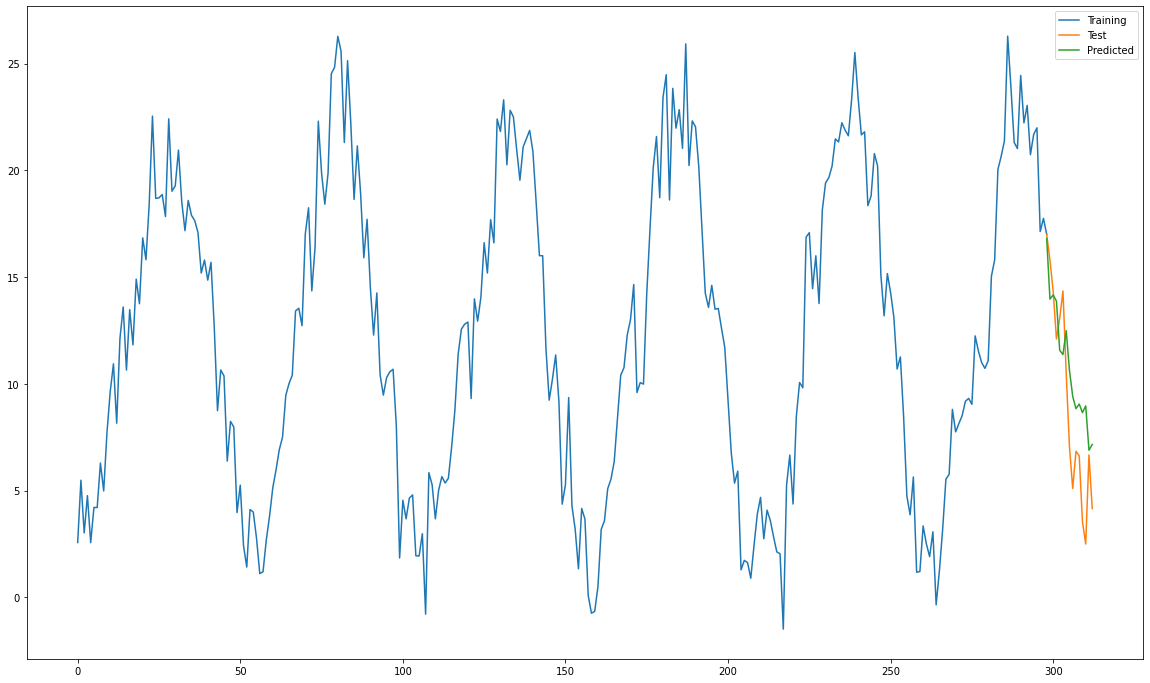

In [294]:
plt.figure(figsize=(20,12))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'Left corner')
plt.show()

In [295]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [296]:
mean_absolute_percentage_error(test, prediction)

83.45192798724406

https://github.com/MyBusinessMaterialLinks/Youtube/blob/main/Timeseries%20Auto-ARIMA/TimeSeries_Auto-ARIMA%20(Youtube).ipynb

In [297]:
from sklearn.metrics import r2_score
r2_score(test, prediction)

0.5688070529146101

In [298]:
test

298    17.004717
299    15.795201
300    14.328571
301    12.103732
302    13.070164
303    14.353373
304    10.502426
305     7.056848
306     5.101467
307     6.843261
308     6.633415
309     3.547048
310     2.499465
311     6.673679
312     4.163620
Name: Temperature, dtype: float64

In [299]:
prediction

,Temperature
298,16.803081
299,13.974355
300,14.165550
301,13.875075
302,11.577278
303,11.373354
304,12.496016
305,10.634787
306,9.414924
307,8.841301
